In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import entropy
import copy
import math
import os
import numpy as np
import matplotlib.pyplot as plt


In [49]:
def count_alphabets(input_string):
    """
    Calculate the total number of alphabets and the number of unique alphabets in the input string.

    Parameters:
    input_string (str): The string to analyze.

    Returns:
    tuple: A tuple containing the total number of alphabets and the number of unique alphabets.
    """
    total_alphabets = len(input_string)
    unique_alphabets = len(set(input_string))
    
    return total_alphabets, unique_alphabets

# Example usage
input_string = "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHI"
total, unique = count_alphabets(input_string)

print(f"Total number of alphabets: {total}")
print(f"Number of unique alphabets: {unique}")


Total number of alphabets: 36
Number of unique alphabets: 9


In [5]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, emsize, nhead, d_hid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emsize, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntokens, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, ntokens)
        self.ntokens=ntokens
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,verbose=False):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        self.store=output.detach().numpy().copy()
        if verbose:
            print(output.shape)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
print(model)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.03, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (linear1): Linear(in_features=20, out_features=20, bias=True)
        (dropout): Dropout(p=0.03, inplace=False)
        (linear2): Linear(in_features=20, out_features=20, bias=True)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03, inplace=False)
        (dropout2): Dropout(p=0.03, inplace=False)
      )
    )
  )
  (encoder): Embedding(8, 20)
  (decoder): Linear(in_features=20, out_features=8, bias=True)
)


In [7]:
def test(model, source, target):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        
        # The output is [sequence_length, batch_size, ntokens]. Get the most likely token predictions
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability
        print('prediction shape', predictions.shape)
        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions
        
    accuracy = correct / total  # Calculate the accuracy
    return accuracy

In [58]:
#last four notes

def getTrainingData(songStrings, nrOfSongs):
    notes = list("ABCDEFGHI")
    chord = [[0], [1], [2], [3], [4], [5], [6], [7],[8]]
    source = []
    target = []
    for s in range(nrOfSongs):
        for i in range(42):
            sentence = []
            answer = []
            for j in range(4):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return np.array(source), np.array(target)

def split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction):
    total_rows = source.shape[0] // 2
    first_set_rows = int(total_rows * fraction)
    second_set_rows = total_rows - first_set_rows

    first_set_indices = np.random.choice(range(total_rows), first_set_rows, replace=False)
    second_set_indices = np.random.choice(range(total_rows, 2 * total_rows), second_set_rows, replace=False)

    combined_indices = np.concatenate((first_set_indices, second_set_indices))
    np.random.shuffle(combined_indices)

    input_list = source[combined_indices]
    output_list = target[combined_indices]

    return input_list, output_list

# Data generation and preparation
songStrings = np.array([
    #"CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    "ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF"
    #"AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED"
])

source_mixed, target_mixed = getTrainingData(songStrings, 2)
fraction = 0.5
input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source_mixed, target_mixed, fraction)

print(input_list.shape, output_list.shape)
print(source_mixed.shape, target.shape)



(42, 4) (42, 4)
(84, 4) (42, 4)


In [59]:
# Simulating the I and O arrays with random data for demonstration

# Flattening and printing I and O arrays
for i in range(32):
    print(f"I[{i}].flatten(): {source_mixed[i].flatten()}, O[{i}].flatten(): {target_mixed[i].flatten()}")

# Checking the size of O and I
I_sizes = [arr.size for arr in source_mixed]
O_sizes = [arr.size for arr in target_mixed]
I_sizes, O_sizes



I[0].flatten(): [0 1 2 3], O[0].flatten(): [1 2 3 4]
I[1].flatten(): [1 2 3 4], O[1].flatten(): [2 3 4 5]
I[2].flatten(): [2 3 4 5], O[2].flatten(): [3 4 5 6]
I[3].flatten(): [3 4 5 6], O[3].flatten(): [4 5 6 7]
I[4].flatten(): [4 5 6 7], O[4].flatten(): [5 6 7 8]
I[5].flatten(): [5 6 7 8], O[5].flatten(): [6 7 8 0]
I[6].flatten(): [6 7 8 0], O[6].flatten(): [7 8 0 1]
I[7].flatten(): [7 8 0 1], O[7].flatten(): [8 0 1 2]
I[8].flatten(): [8 0 1 2], O[8].flatten(): [0 1 2 3]
I[9].flatten(): [0 1 2 3], O[9].flatten(): [1 2 3 4]
I[10].flatten(): [1 2 3 4], O[10].flatten(): [2 3 4 5]
I[11].flatten(): [2 3 4 5], O[11].flatten(): [3 4 5 6]
I[12].flatten(): [3 4 5 6], O[12].flatten(): [4 5 6 7]
I[13].flatten(): [4 5 6 7], O[13].flatten(): [5 6 7 8]
I[14].flatten(): [5 6 7 8], O[14].flatten(): [6 7 8 0]
I[15].flatten(): [6 7 8 0], O[15].flatten(): [7 8 0 1]
I[16].flatten(): [7 8 0 1], O[16].flatten(): [8 0 1 2]
I[17].flatten(): [8 0 1 2], O[17].flatten(): [0 1 2 3]
I[18].flatten(): [0 1 2 3], O[

([4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4],
 [4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4])

In [60]:
# Simulating the I and O arrays with random data for demonstration

# Flattening and printing I and O arrays
for i in range(42):
    print(f"I[{i}].flatten(): {input_list[i].flatten()}, O[{i}].flatten(): {output_list[i].flatten()}")

# Checking the size of O and I
I_sizes = [arr.size for arr in input_list]
O_sizes = [arr.size for arr in output_list]
I_sizes, O_sizes

I[0].flatten(): [4 5 8 6], O[0].flatten(): [5 8 6 7]
I[1].flatten(): [8 6 7 0], O[1].flatten(): [6 7 0 1]
I[2].flatten(): [3 4 5 6], O[2].flatten(): [4 5 6 7]
I[3].flatten(): [3 4 5 6], O[3].flatten(): [4 5 6 7]
I[4].flatten(): [0 1 2 3], O[4].flatten(): [1 2 3 4]
I[5].flatten(): [7 8 0 1], O[5].flatten(): [8 0 1 2]
I[6].flatten(): [7 8 0 1], O[6].flatten(): [8 0 1 2]
I[7].flatten(): [2 3 4 5], O[7].flatten(): [3 4 5 0]
I[8].flatten(): [5 8 6 7], O[8].flatten(): [8 6 7 0]
I[9].flatten(): [1 2 3 4], O[9].flatten(): [2 3 4 5]
I[10].flatten(): [5 0 1 2], O[10].flatten(): [0 1 2 3]
I[11].flatten(): [3 4 5 8], O[11].flatten(): [4 5 8 6]
I[12].flatten(): [2 3 4 5], O[12].flatten(): [3 4 5 8]
I[13].flatten(): [4 5 8 6], O[13].flatten(): [5 8 6 7]
I[14].flatten(): [4 5 6 7], O[14].flatten(): [5 6 7 8]
I[15].flatten(): [2 3 4 5], O[15].flatten(): [3 4 5 6]
I[16].flatten(): [1 2 3 4], O[16].flatten(): [2 3 4 5]
I[17].flatten(): [7 0 1 2], O[17].flatten(): [0 1 2 3]
I[18].flatten(): [3 4 5 0], O[

([4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4],
 [4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4])

Epoch 1, Loss: 0.0000
prediction shape torch.Size([4, 42])


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_29802/2366339544.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_29802/2366339544.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Epoch 101, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 201, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 301, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 401, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 501, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 601, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 701, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 801, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 901, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 1001, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 1101, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 1201, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 1301, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 1401, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 1501, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 1601, Loss: 0.0000
prediction shape torch.Size([4, 42])
Epoch 1701, Loss:

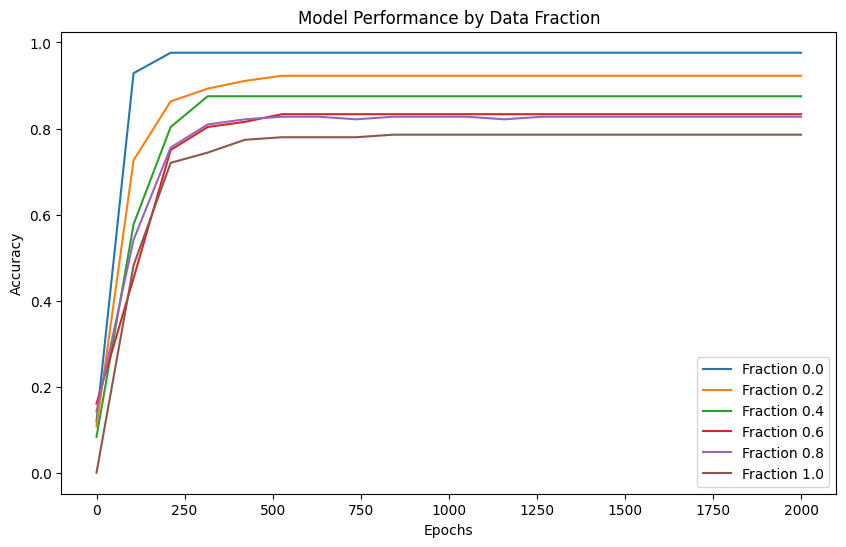

In [18]:
# four notes

# Initialize parameters for the model and environment setup
ntokens = 9  # Size of vocabulary
emsize = 8  # Embedding dimension
nhead = 2  # Number of heads in the nn.MultiheadAttention
d_hid = 8  # Dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # Number of nn.TransformerEncoderLayer
dropout = 0.03  # Dropout probability
learning_rate = 1e-3
num_epochs = 2000
fractions = np.arange(0, 101, 20) / 100
model_dir = "overlap_transformers_dataset_changed"
os.makedirs(model_dir, exist_ok=True)

source, target = getTrainingData(songStrings, 2)  # Assume this function is properly defined

# Dictionary to store accuracy lists for each fraction
fraction_accuracies = {}

for fraction in fractions:
    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

    W = []  # Reset W for each fraction
    model.train()  # Set the model to training mode
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        
        optimizer.zero_grad()  # Clear the gradients
        
        source_tensor = torch.tensor(input_list, dtype=torch.long)
        target_tensor = torch.tensor(output_list, dtype=torch.long)

        src = source_tensor.transpose(0, 1)
        tgt = target_tensor.transpose(0, 1)
        
        output = model(src)
        
        output_flat = output.view(-1, model.ntokens)
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(output_flat, tgt_flat)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:  # Record accuracy at specified interval
            avg_loss = total_loss / src.size(1)
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            
            acc = test(model, source_tensor, target_tensor)  # Assume this function returns accuracy
            W.append(acc)

    fraction_accuracies[fraction] = W  # Store accuracies for the current fraction

    model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
    torch.save(model.state_dict(), model_save_path)

# Plot all accuracies in the same plot
plt.figure(figsize=(10, 6))
for fraction, accuracies in fraction_accuracies.items():
    epochs = np.linspace(0, num_epochs, len(accuracies))  # Assuming accuracies are recorded evenly throughout training
    plt.plot(epochs, accuracies, label=f'Fraction {fraction}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance by Data Fraction')
plt.legend()
plt.show()


Model 0, Fraction 0.00, Epoch 1, Loss: 2.2071
prediction shape torch.Size([4, 42])


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_88431/2366339544.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_88431/2366339544.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Model 0, Fraction 0.00, Epoch 101, Loss: 1.2761
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 201, Loss: 0.5948
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 301, Loss: 0.2836
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 401, Loss: 0.1732
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 501, Loss: 0.1275
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 601, Loss: 0.1046
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 701, Loss: 0.0916
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 801, Loss: 0.0835
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 901, Loss: 0.0781
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 1001, Loss: 0.0743
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 1101, Loss: 0.0716
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 1201, Loss: 0.0695
prediction sha

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model 0, Fraction 0.20, Epoch 1, Loss: 2.2075
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.20, Epoch 101, Loss: 1.2928
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.20, Epoch 201, Loss: 0.5990
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.20, Epoch 301, Loss: 0.3046
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.20, Epoch 401, Loss: 0.1937
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.20, Epoch 501, Loss: 0.1488
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.20, Epoch 601, Loss: 0.1267
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.20, Epoch 701, Loss: 0.1142
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.20, Epoch 801, Loss: 0.1064
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.20, Epoch 901, Loss: 0.1012
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.20, Epoch 1001, Loss: 0.0975
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.20, Epoch 1101, Loss: 0.0948
prediction shape 

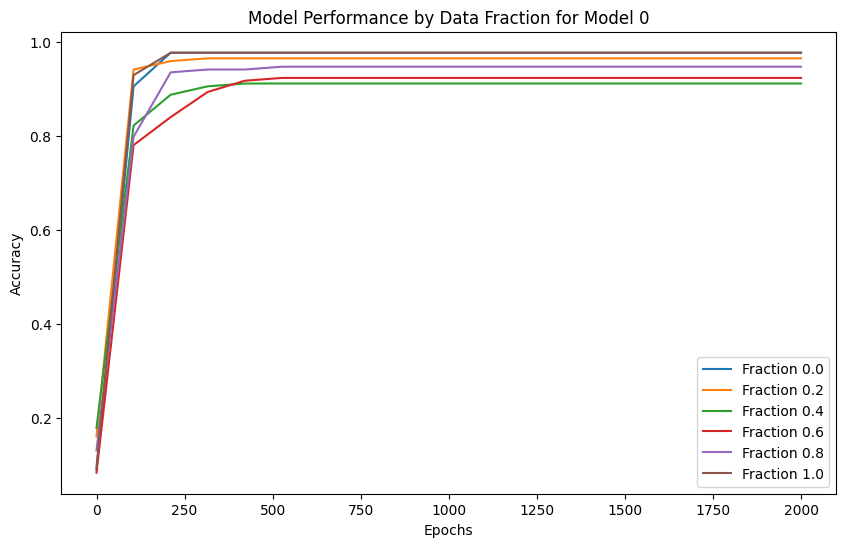

Model 1, Fraction 0.00, Epoch 1, Loss: 2.2104
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 101, Loss: 1.2662
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 201, Loss: 0.6445
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 301, Loss: 0.3340
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 401, Loss: 0.1995
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 501, Loss: 0.1410
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 601, Loss: 0.1122
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 701, Loss: 0.0962
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 801, Loss: 0.0865
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 901, Loss: 0.0801
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 1001, Loss: 0.0758
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 1101, Loss: 0.0726
prediction shape 

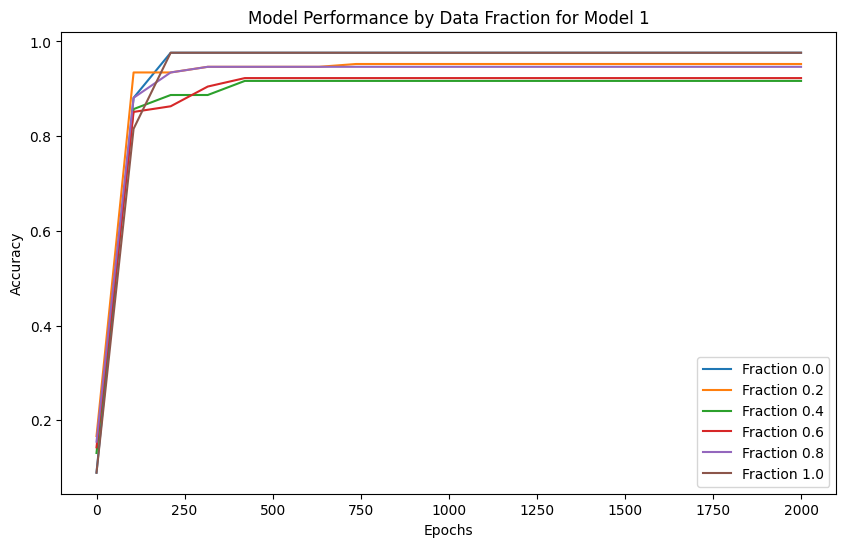

Model 2, Fraction 0.00, Epoch 1, Loss: 2.2069
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 101, Loss: 1.2708
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 201, Loss: 0.6307
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 301, Loss: 0.2985
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 401, Loss: 0.1774
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 501, Loss: 0.1290
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 601, Loss: 0.1056
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 701, Loss: 0.0924
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 801, Loss: 0.0841
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 901, Loss: 0.0787
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 1001, Loss: 0.0749
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 1101, Loss: 0.0721
prediction shape 

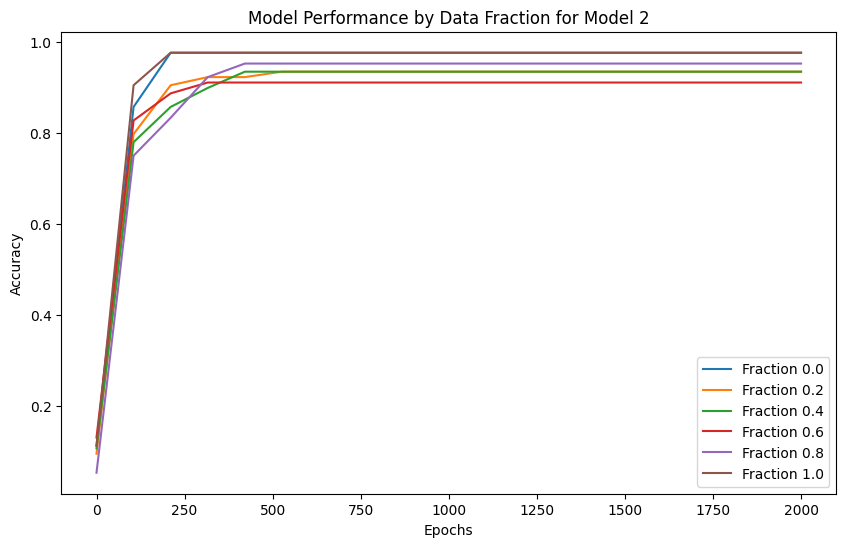

Model 3, Fraction 0.00, Epoch 1, Loss: 2.2251
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 101, Loss: 1.3280
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 201, Loss: 0.5987
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 301, Loss: 0.2835
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 401, Loss: 0.1757
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 501, Loss: 0.1299
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 601, Loss: 0.1066
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 701, Loss: 0.0931
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 801, Loss: 0.0847
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 901, Loss: 0.0791
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 1001, Loss: 0.0751
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 1101, Loss: 0.0722
prediction shape 

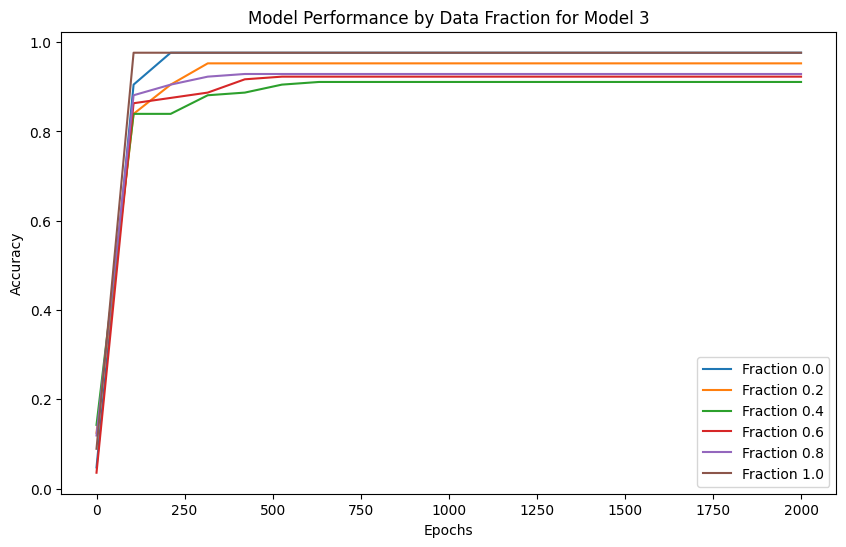

Model 4, Fraction 0.00, Epoch 1, Loss: 2.1954
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 101, Loss: 1.2477
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 201, Loss: 0.5512
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 301, Loss: 0.2753
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 401, Loss: 0.1710
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 501, Loss: 0.1263
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 601, Loss: 0.1038
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 701, Loss: 0.0910
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 801, Loss: 0.0830
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 901, Loss: 0.0777
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 1001, Loss: 0.0740
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 1101, Loss: 0.0713
prediction shape 

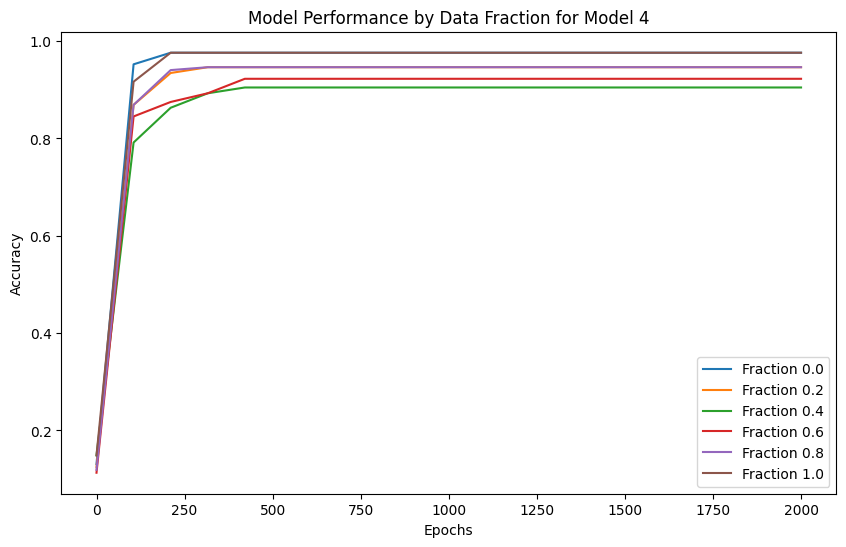

In [10]:
import os
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# Parameters
ntokens = 9
emsize = 8
nhead = 2
d_hid = 8
nlayers = 2
dropout = 0.03
learning_rate = 1e-3
num_epochs = 2000
fractions = np.arange(0, 101, 20) / 100
num_models = 5  # Train 10 different models

# Load the song strings (assuming already defined)
#songStrings = ["Song data here..."]

for model_idx in range(num_models):
    model_dir = f"overlap_transformers_dataset_changed_Nmodels/model_{model_idx}"
    os.makedirs(model_dir, exist_ok=True)

    source, target = getTrainingData(songStrings, 2)
    fraction_accuracies = {}

    for fraction in fractions:
        model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
        W = []
        model.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            source_tensor = torch.tensor(input_list, dtype=torch.long)
            target_tensor = torch.tensor(output_list, dtype=torch.long)

            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            loss = criterion(output.view(-1, model.ntokens), tgt.reshape(-1))
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                avg_loss = loss.item()
                print(f'Model {model_idx}, Fraction {fraction:.2f}, Epoch {epoch+1}, Loss: {avg_loss:.4f}')
                acc = test(model, source_tensor, target_tensor)
                W.append(acc)

        fraction_accuracies[fraction] = W
        model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        torch.save(model.state_dict(), model_save_path)

    # Optionally plot accuracies for each model or save the data for further analysis
    plt.figure(figsize=(10, 6))
    for fraction, accuracies in fraction_accuracies.items():
        epochs = np.linspace(0, num_epochs, len(accuracies))
        plt.plot(epochs, accuracies, label=f'Fraction {fraction}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Model Performance by Data Fraction for Model {model_idx}')
    plt.legend()
    plt.show()


In [19]:
#last four notes
fractions = np.arange(0, 101, 20) / 100

# Define a directory to save/load models
model_dir = "overlap_transformers_dataset_changed"

# Assuming getTrainingData and split_and_shuffle_data_randomly_based_on_fraction are defined as before

# Load the song strings
songStrings = np.array([
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    "ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF"
])

# Initialize the model parameters here (ntokens, emsize, etc.), same as during training
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

accuracies = np.zeros((len(fractions), len(songStrings))) 
 # For storing accuracies of each song at each fraction
for frac_idx, fraction in enumerate(fractions):

    for song_idx, song in enumerate(songStrings):
        
        source, target = getTrainingData(np.array([song]), 1)  # Get data for the current song

        # for frac_idx, fraction in enumerate(fractions):

        model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        model.load_state_dict(torch.load(model_path))
        model.eval()  # Set the model to evaluation mode

        correct = 0
        total = 0

        # input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)
        # source_tensor = torch.tensor(input_list, dtype=torch.long)
        # target_tensor = torch.tensor(output_list, dtype=torch.long)

        source_tensor = torch.tensor(source, dtype=torch.long)
        target_tensor = torch.tensor(target, dtype=torch.long)

        with torch.no_grad():
            
            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            predictions = output.argmax(dim=2)

            correct += (predictions == tgt).sum().item()
            total += tgt.numel()

        accuracy = correct / total
        accuracies[frac_idx, song_idx] = accuracy  # Store accuracy for this song at this fraction

# Print or process the accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for song {song_idx}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"Fraction: {fraction}, Accuracy: {accuracies[frac_idx, song_idx]}")


Accuracies for song 0:
Fraction: 0.0, Accuracy: 0.0
Fraction: 0.2, Accuracy: 0.48214285714285715
Fraction: 0.4, Accuracy: 0.5476190476190477
Fraction: 0.6, Accuracy: 0.7023809523809523
Fraction: 0.8, Accuracy: 0.7738095238095238
Fraction: 1.0, Accuracy: 0.7857142857142857
Accuracies for song 1:
Fraction: 0.0, Accuracy: 0.9761904761904762
Fraction: 0.2, Accuracy: 0.9464285714285714
Fraction: 0.4, Accuracy: 0.9702380952380952
Fraction: 0.6, Accuracy: 0.7976190476190477
Fraction: 0.8, Accuracy: 0.6547619047619048
Fraction: 1.0, Accuracy: 0.14285714285714285


In [12]:
import os
import numpy as np
import torch

# Assuming TransformerModel and necessary data functions are properly defined
# Initialize the model parameters (keep these consistent with training)
ntokens = 9
emsize = 8
nhead = 2
d_hid = 8
nlayers = 2
dropout = 0.03

# Define the directory where models are saved
base_model_dir = "overlap_transformers_dataset_changed_Nmodels"

# Fractions and song strings for which models were trained
fractions = np.arange(0, 101, 20) / 100
songStrings = np.array([
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    "ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF"
])

# Array to store accuracies
accuracies = np.zeros((len(fractions), len(songStrings), num_models))  # Added a dimension for models

# Load and test each model for each fraction and song
for model_idx in range(5):  # You trained 10 models
    for frac_idx, fraction in enumerate(fractions):
        for song_idx, song in enumerate(songStrings):
            model_dir = f"{base_model_dir}/model_{model_idx}"
            model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
            
            # Load model if it exists
            if os.path.exists(model_path):
                model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
                model.load_state_dict(torch.load(model_path))
                model.eval()

                source, target = getTrainingData(np.array([song]), 1)
                source_tensor = torch.tensor(source, dtype=torch.long)
                target_tensor = torch.tensor(target, dtype=torch.long)

                with torch.no_grad():
                    src = source_tensor.transpose(0, 1)
                    tgt = target_tensor.transpose(0, 1)
                    output = model(src)
                    predictions = output.argmax(dim=2)

                    correct = (predictions == tgt).sum().item()
                    total = tgt.numel()

                    accuracy = correct / total
                    accuracies[frac_idx, song_idx, model_idx] = accuracy
            else:
                print(f"Model not found: {model_path}")

# Optionally, average accuracies across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension

# Print or process the average accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for Song {song_idx + 1}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"  Fraction {fraction:.2f}, Average Accuracy: {average_accuracies[frac_idx, song_idx]:.4f}")


Accuracies for Song 1:
  Fraction 0.00, Average Accuracy: 0.6905
  Fraction 0.20, Average Accuracy: 0.8048
  Fraction 0.40, Average Accuracy: 0.8417
  Fraction 0.60, Average Accuracy: 0.8976
  Fraction 0.80, Average Accuracy: 0.9619
  Fraction 1.00, Average Accuracy: 0.9762
Accuracies for Song 2:
  Fraction 0.00, Average Accuracy: 0.9762
  Fraction 0.20, Average Accuracy: 0.9619
  Fraction 0.40, Average Accuracy: 0.9369
  Fraction 0.60, Average Accuracy: 0.8786
  Fraction 0.80, Average Accuracy: 0.7952
  Fraction 1.00, Average Accuracy: 0.6905


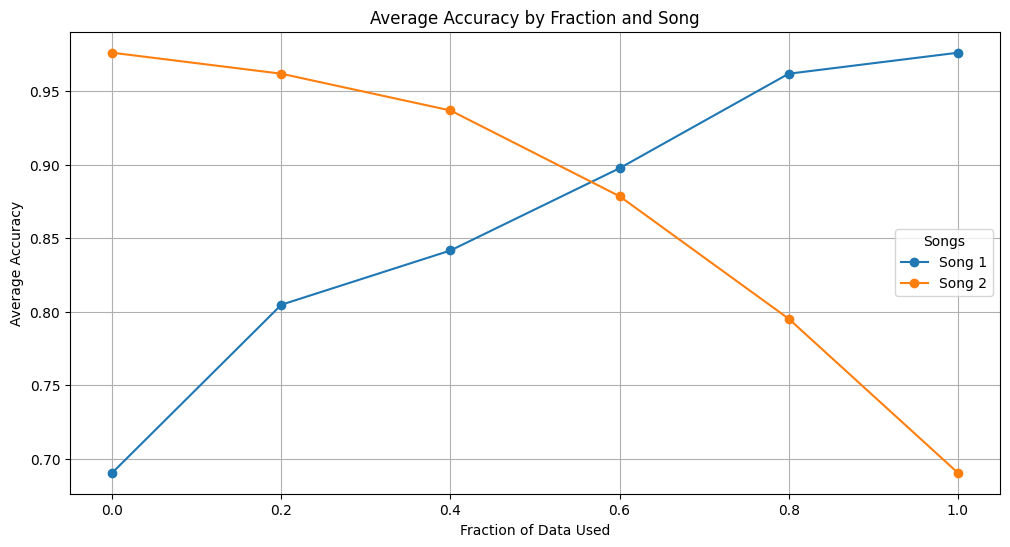

In [14]:
# Plotting the accuracies
plt.figure(figsize=(12, 6))
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, average_accuracies[:, song_idx], marker='o', label=f'Song {song_idx + 1}')

plt.title('Average Accuracy by Fraction and Song')
plt.xlabel('Fraction of Data Used')
plt.ylabel('Average Accuracy')
plt.legend(title="Songs")
plt.grid(True)
plt.show()

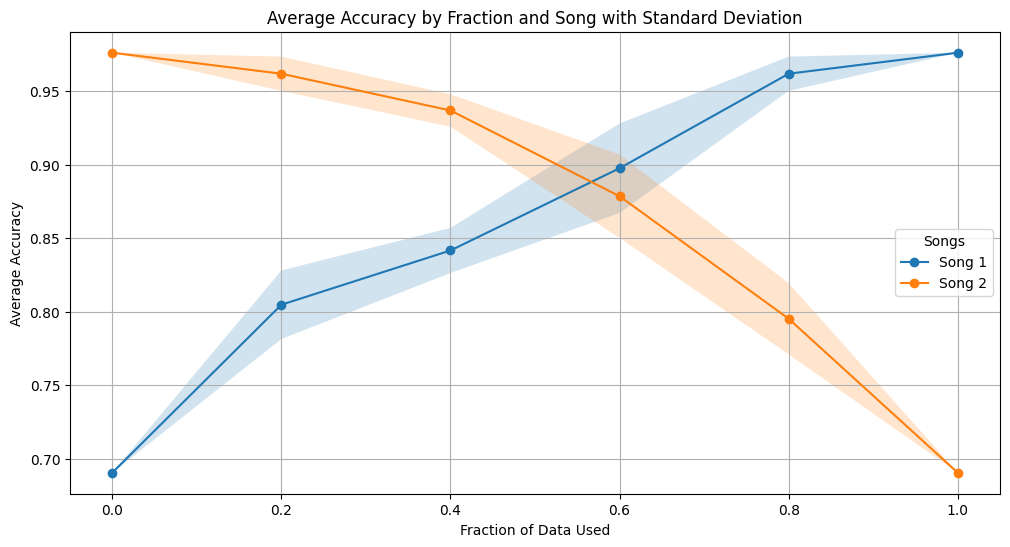

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming accuracies are already calculated and available
# Calculate the average accuracies and standard deviation across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension
std_dev_accuracies = accuracies.std(axis=2)  # Standard deviation over the model dimension

# Plotting the accuracies with standard deviation
plt.figure(figsize=(12, 6))
for song_idx, song in enumerate(songStrings):
    # Generate the x-values for the fractions
    x_values = fractions
    y_values = average_accuracies[:, song_idx]
    y_err = std_dev_accuracies[:, song_idx]

    plt.plot(x_values, y_values, marker='o', label=f'Song {song_idx + 1}')
    plt.fill_between(x_values, (y_values - y_err), (y_values + y_err), alpha=0.2)

plt.title('Average Accuracy by Fraction and Song with Standard Deviation')
plt.xlabel('Fraction of Data Used')
plt.ylabel('Average Accuracy')
plt.legend(title="Songs")
plt.grid(True)
plt.show()


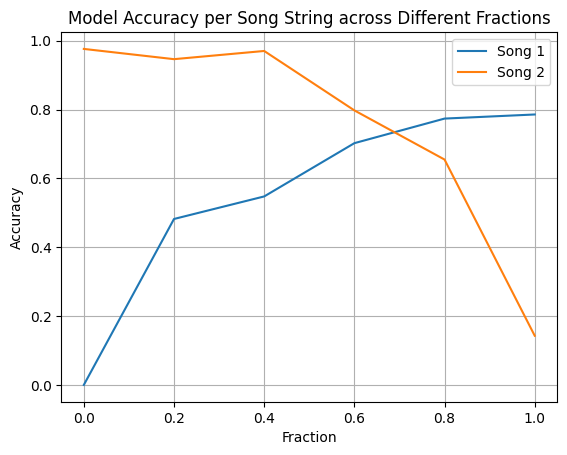

In [20]:

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions')
plt.legend()
plt.grid(True)
plt.show()


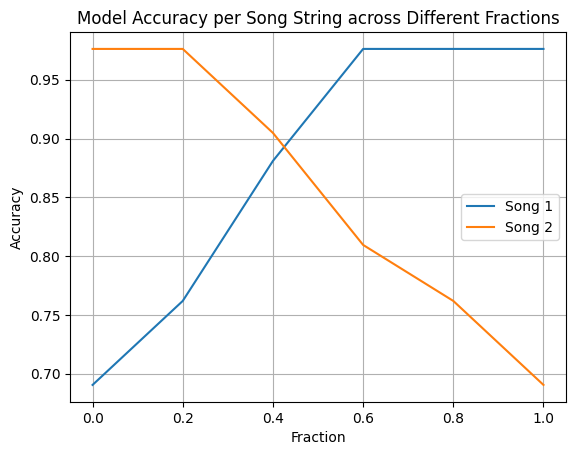

In [15]:

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions')
plt.legend()
plt.grid(True)
plt.show()


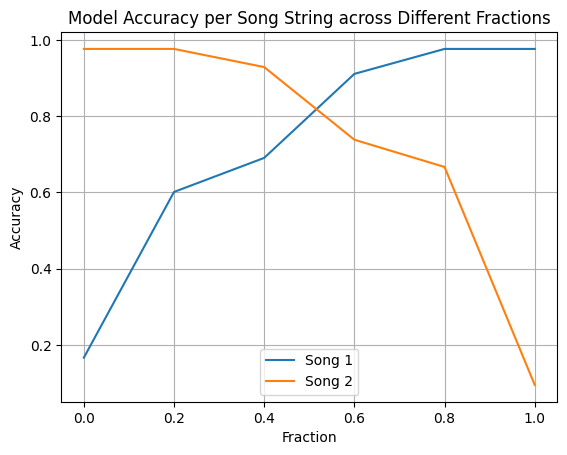

In [35]:

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
import torch.nn.functional as F

def train_and_evaluate(model, source, target, num_epochs, accuracy_thresholds):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    accuracy_epochs = {acc: None for acc in accuracy_thresholds}

    source_tensor = torch.tensor(source, dtype=torch.long)
    target_tensor = torch.tensor(target, dtype=torch.long)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        src = source_tensor.transpose(0, 1)
        tgt = target_tensor.transpose(0, 1)

        output = model(src)
        loss = criterion(output.view(-1, model.ntokens), tgt.reshape(-1))
        loss.backward()
        optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            output_prob = F.softmax(output, dim=2)  # Softmax over the class dimension
            target_one_hot = F.one_hot(tgt, num_classes=ntokens).float()  # One-hot encode the target
            
            mse = F.mse_loss(output_prob, target_one_hot)  # Calculate MSE between probabilities and one-hot targets
            predictions = output.argmax(dim=2)
            correct = (predictions == tgt).sum()
            total = tgt.numel()
            accuracy = correct.float() / total

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}, MSE: {mse.item():.4f}, Accuracy: {accuracy.item():.4f}')

            for acc in accuracy_thresholds:
                if accuracy >= acc and accuracy_epochs[acc] is None:
                    accuracy_epochs[acc] = epoch
                    if all(accuracy_epochs.values()):
                        break  # Break early if all thresholds are met

    return accuracy_epochs, mse.item()


In [36]:

# Parameters
ntokens = 9
emsize = 10
nhead = 2
d_hid = 10
nlayers = 2
dropout = 0.03
learning_rate = 1e-3
num_epochs = 3000
accuracy_thresholds = [0.85,0.90]

# Load the song strings
songStrings = np.array([
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF", # normal
    "IHGFEDCBAIHGFEDCBAIHGFEDCBAIHGFEDCBAIHGFED", # reverse
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC", # daisybells
    "ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF", # igh contradiction
    "ABCDAFGHIEBCDEAGHIAFCDEFIHIABADEFGCIABCBEF", # 5th note different 
    "AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED", # every 2nd note different
])

song_performance = []

for song in songStrings:
    source, target = getTrainingData(np.array([song]), 1)
    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
    epochs_to_accuracy, mse = train_and_evaluate(model, source, target, num_epochs, accuracy_thresholds)
    song_performance.append({
        'song': song,
        'epochs_to_accuracy': epochs_to_accuracy,
        'mse': mse
    })

for performance in song_performance:
    print(f"Song: {performance['song']}")
    for acc, epoch in performance['epochs_to_accuracy'].items():
        print(f"  Accuracy {acc*100}% reached at epoch: {epoch if epoch is not None else 'Not reached'}")
    print(f"  MSE: {performance['mse']}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0, Loss: 2.2281, MSE: 0.0995, Accuracy: 0.1250
Epoch 100, Loss: 1.2207, MSE: 0.0630, Accuracy: 0.9107
Epoch 200, Loss: 0.5215, MSE: 0.0227, Accuracy: 0.9643
Epoch 300, Loss: 0.2469, MSE: 0.0085, Accuracy: 0.9762
Epoch 400, Loss: 0.1608, MSE: 0.0061, Accuracy: 0.9702
Epoch 500, Loss: 0.1157, MSE: 0.0048, Accuracy: 0.9762
Epoch 600, Loss: 0.1037, MSE: 0.0051, Accuracy: 0.9762
Epoch 700, Loss: 0.0882, MSE: 0.0047, Accuracy: 0.9762
Epoch 800, Loss: 0.0753, MSE: 0.0040, Accuracy: 0.9762
Epoch 900, Loss: 0.0712, MSE: 0.0041, Accuracy: 0.9762
Epoch 1000, Loss: 0.0722, MSE: 0.0043, Accuracy: 0.9762
Epoch 1100, Loss: 0.0764, MSE: 0.0049, Accuracy: 0.9702
Epoch 1200, Loss: 0.0724, MSE: 0.0046, Accuracy: 0.9762
Epoch 1300, Loss: 0.0665, MSE: 0.0042, Accuracy: 0.9762
Epoch 1400, Loss: 0.0652, MSE: 0.0042, Accuracy: 0.9762
Epoch 1500, Loss: 0.0653, MSE: 0.0043, Accuracy: 0.9762
Epoch 1600, Loss: 0.0669, MSE: 0.0045, Accuracy: 0.9762
Epoch 1700, Loss: 0.0636, MSE: 0.0043, Accuracy: 0.9762
Epoc

In [25]:
original_string = "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF"
reversed_string = original_string[::-1]  # Use slicing to reverse the string

print("Original:", original_string)
print("Reversed:", reversed_string)


Original: ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF
Reversed: FEDCBAIHGFEDCBAIHGFEDCBAIHGFEDCBAIHGFEDCBA


<Figure size 1000x500 with 0 Axes>

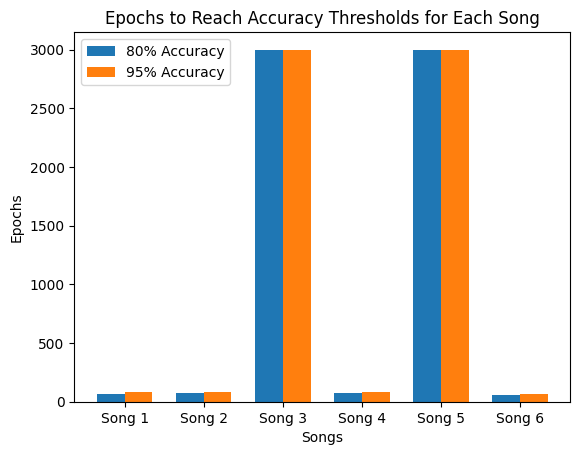

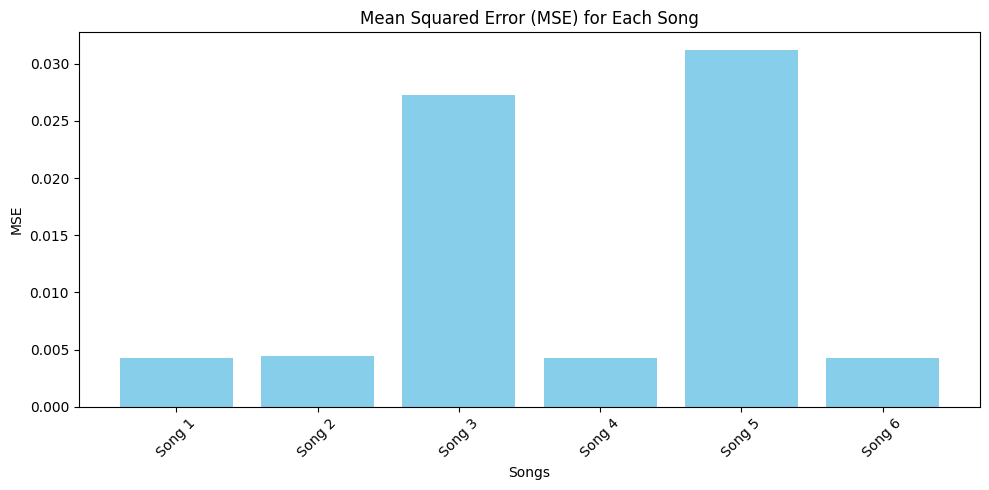

In [37]:
import matplotlib.pyplot as plt

# Assuming 'song_performance' already has the relevant data
# Prepare data for plotting
epochs_data_80 = []
epochs_data_95 = []
mse_data = []
song_labels = []

for i, performance in enumerate(song_performance):
    song_labels.append(f"Song {i+1}")  # Label songs sequentially
    epochs_data_80.append(performance['epochs_to_accuracy'][0.85] if performance['epochs_to_accuracy'][0.85] is not None else num_epochs)
    epochs_data_95.append(performance['epochs_to_accuracy'][0.90] if performance['epochs_to_accuracy'][0.90] is not None else num_epochs)
    mse_data.append(performance['mse'])

# Plotting the epochs at which each accuracy threshold was reached
plt.figure(figsize=(10, 5))
x = range(len(song_labels))  # x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, epochs_data_80, width, label='80% Accuracy')
rects2 = ax.bar([p + width for p in x], epochs_data_95, width, label='95% Accuracy')

ax.set_xlabel('Songs')
ax.set_ylabel('Epochs')
ax.set_title('Epochs to Reach Accuracy Thresholds for Each Song')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(song_labels)
ax.legend()

plt.show()

# Plotting the MSE for each song
plt.figure(figsize=(10, 5))
plt.bar(song_labels, mse_data, color='skyblue')
plt.title('Mean Squared Error (MSE) for Each Song')
plt.xlabel('Songs')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
